In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# STEP 1: DATA IMPORTING 

In [105]:
retail = pd.read_csv('OnlineRetail.csv', encoding ='ISO-8859-1')

In [106]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [107]:
retail.shape

(541909, 8)

In [108]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [109]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# STEP 2: DATA Cleaning

In [110]:
# Calculating missing value % contribution in DataFrame

data_null = round(retail.isna().sum() / len (retail)* 100, 2)

In [111]:
data_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [112]:
# Droping rows having missing values as it is A KEY

retail = retail.dropna()
retail.shape

(406829, 8)

In [113]:
# changing the datatype of Customer ID as per Bussiness understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

In [114]:
#retail.drop_duplicates(subset=['InvoiceNo','InvoiceDate']).groupby('CustomerID')['InvoiceNo'].count().reset_index().head()

# STEP 3: DATA PREPARATION

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [115]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [116]:
# NEW ATTRIBUTE : Monetory

retail['Amount'] = retail['Quantity'] * retail['UnitPrice']

rfm_m = retail.groupby('CustomerID')['Amount'].sum()  #creating group of sum of amount spend by each group
rfm_m = rfm_m.reset_index() #reseting index
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [117]:
# NEW ATTRIBUTE : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID','Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [118]:
rfm = pd.merge(rfm_m,rfm_f, on='CustomerID', how='inner'); rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [119]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [120]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null object
Country        406829 non-null object
Amount         406829 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 31.0+ MB


In [121]:
max_date = max(retail['InvoiceDate']);max_date

Timestamp('2011-12-09 12:50:00')

In [122]:
retail['Diff'] = max_date - retail['InvoiceDate'];retail['Diff'].head()

0   373 days 04:24:00
1   373 days 04:24:00
2   373 days 04:24:00
3   373 days 04:24:00
4   373 days 04:24:00
Name: Diff, dtype: timedelta64[ns]

In [123]:
#calculating Recency Factor

rfm_r = retail.groupby('CustomerID')['Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [124]:
# removing Hours and minutes from datetime

rfm_r['Diff'] =rfm_r['Diff'].dt.days
rfm_r.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [125]:
# Merge the dataframes to get final RFM dataframes

rfm = pd.merge(rfm, rfm_r, on='CustomerID',how='inner')
rfm.columns = ['CustomerID','Amount','Frequency','Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [126]:
rfm.describe()

,Amount,Frequency,Recency
count,4372.000000,4372.000000,4372.000000
mean,1898.459701,93.053294,91.047118
std,8219.345141,232.471608,100.765435
min,-4287.630000,1.000000,0.000000
25%,293.362500,17.000000,16.000000
50%,648.075000,42.000000,49.000000
75%,1611.725000,102.000000,142.000000
max,279489.020000,7983.000000,373.000000


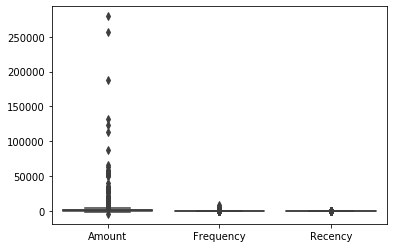

In [127]:
# Showing Outlier 

attributes = ['Amount','Frequency','Recency']
sns.boxplot(data=rfm[attributes])

In [128]:
# Outliers treatment by IQR method

#removing outlier in Amount

Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5 * IQR) & (rfm.Amount <= Q3 +1.5 * IQR)]

#removing outlier in Frequency

Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5 * IQR) & (rfm.Amount <= + 1.5 * IQR)]

#removing outlier in Recency

Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5 * IQR) & (rfm.Amount <= Q3 + 1.5 * IQR)]

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [129]:
# Rescaling Attributes

rfm_df = rfm[['Amount','Frequency','Recency']]

# Intentiate
scaler = StandardScaler()

# fit - transform

rfm_df_scaler = scaler.fit_transform(rfm_df)
rfm_df_scaler.shape

(4223, 3)

In [130]:
rfm_df_scaler = pd.DataFrame(rfm_df_scaler)
rfm_df_scaler.columns = ['Amount','Frequency','Recency']
rfm_df_scaler.head()

,Amount,Frequency,Recency
0,-0.859511,-0.705612,2.284006
1,2.460636,1.022576,-0.915137
2,0.524967,-0.427182,-0.194343
3,0.494392,-0.023938,-0.747281
4,-0.601911,-0.561596,2.126023


# Building Model

# K - Means Cluster

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [131]:
# K Means with some arbitary K

kmeans = KMeans(n_clusters=3,max_iter=50)
kmeans.fit(rfm_df_scaler)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [132]:
kmeans.labels_ # it will explain To what cluster each observation belongs

array([2, 1, 0, ..., 0, 1, 0], dtype=int32)

In [133]:
# Find the Optimal number of clusers

In [134]:
# ELbow curve: to get right number of clusters

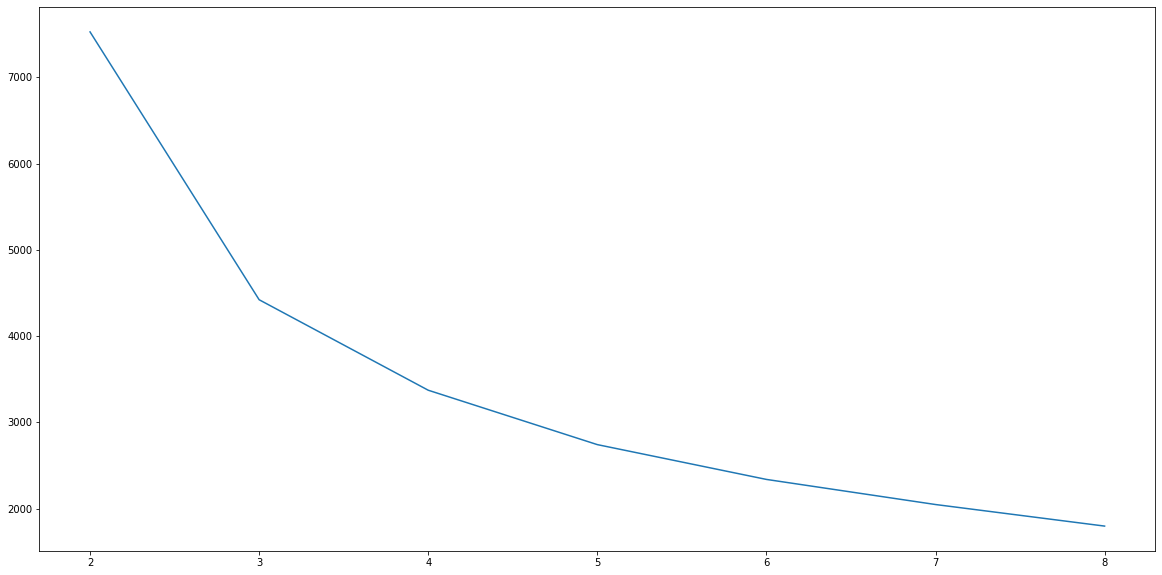

In [135]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaler)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.figure(figsize=(20,10))
plt.plot(range_n_clusters,ssd)


#selected should 4 because more number of clusers more better can be buisness insight (where you don't know the clusters)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [136]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaler)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaler, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.5086550832339513
For n_clusters=3, the silhouette score is 0.49761364843724437
For n_clusters=4, the silhouette score is 0.4825543261452351
For n_clusters=5, the silhouette score is 0.4581170152079551
For n_clusters=6, the silhouette score is 0.41028688360318305
For n_clusters=7, the silhouette score is 0.4119448259629873
For n_clusters=8, the silhouette score is 0.38317105256603756


In [137]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaler)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [138]:
kmeans.labels_

array([2, 1, 0, ..., 0, 1, 0], dtype=int32)

In [139]:
rfm['ClusterID'] = kmeans.labels_

In [140]:
rfm.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


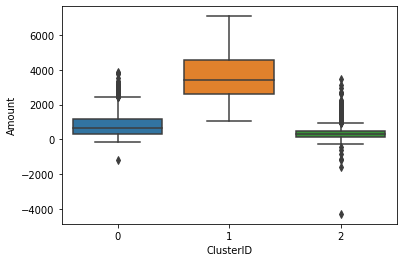

In [141]:
sns.boxplot(x='ClusterID',y='Amount',data=rfm)

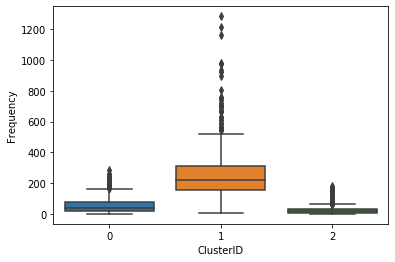

In [142]:
sns.boxplot(x='ClusterID',y='Frequency',data=rfm)

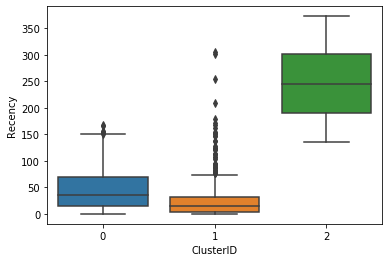

In [143]:
sns.boxplot(x='ClusterID',y='Recency',data=rfm)

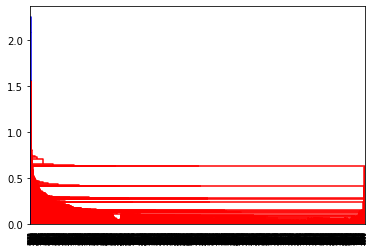

In [144]:
# Single linkage: 

mergings = linkage(rfm_df_scaler, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

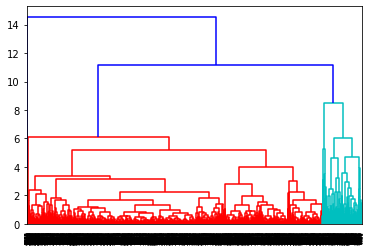

In [145]:
mergings = linkage(rfm_df_scaler, method='complete',metric='euclidean')
dendrogram(mergings)
plt.show()

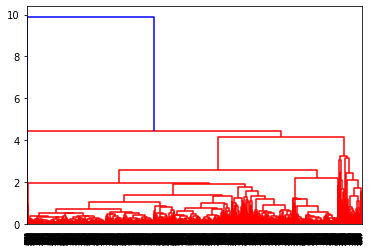

In [146]:
mergings = linkage(rfm_df_scaler,method='average',metric='euclidean')
dendrogram(mergings)
plt.show()

# Cutting dendogram based on K

In [147]:
#3 clusters

cluster_labels = cut_tree(mergings,n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [148]:
rfm['Cluster_labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,ClusterID,Cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0


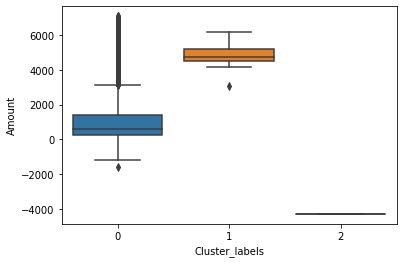

In [149]:
sns.boxplot(x='Cluster_labels',y='Amount',data=rfm)

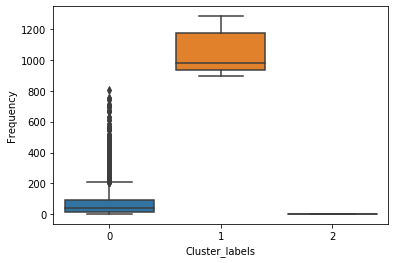

In [150]:
sns.boxplot(x='Cluster_labels',y='Frequency',data=rfm)

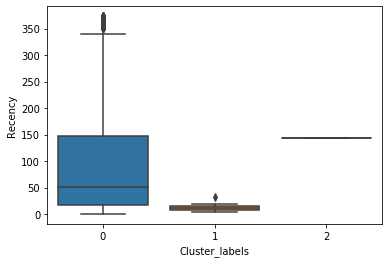

In [153]:
sns.boxplot(x='Cluster_labels',y='Recency',data=rfm)